# Clasificación de correos por medio de naive Bayes

## Laboratorio 2022 - Tarea 3

### Grupo 16

Alexis Baladón, CI: 5.574.612-4

Ignacio Viscardi, CI: 5.066.666-2

Rafael Castelli, CI: 5.079.391-2

## 1 Requisitos para reproducción de algoritmo
Para correr el presente notebook se deberán instalar las siguientes dependencias. Queda un script para su instalación automática.

### 1.1 Requisitos para reproducción de algoritmo
Luego de realizar las instalaciones debe reiniciar el notebook.

In [ ]:
%pip install pickle
%pip install regex
%pip install nltk
%pip install sklearn
%pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
%pip install pandas
%pip install wordcloud

### 1.2 Librería nlkt y sus descargas necesarias:
Luego de realizar las instalaciones debe reiniciar el notebook.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("brown")
nltk.download("cess_esp")

### 1.3 Constantes utilizadas: 

In [3]:
DICTIONARIES_LOCATIONS = ["./dictionaries/anArrayOfSpanishWords.json", "./dictionaries/anArrayOfEnglishWords.json"]
OUR_DICTIONARY = "./dictionaries/our_dictionary.json"
FULL_DICTIONARY = "./dictionaries/full_dictionary.json"
STOP_WORDS_LOCATION = ["./dictionaries/spanishStopWords.json", "./dictionaries/englishStopWords.json"]
NON_SPAM_MESSAGES_DUMP_LOCATION = "./messages.json"
SPAM_MESSAGES_DUMP_LOCATION = "./spam_messages.json"
MERGED_NON_SPAM_MESSAGES_DUMP_LOCATION = "./merged_messages.json"
MERGED_SPAM_MESSAGES_DUMP_LOCATION = "./merged_spam_messages.json"
SEED = 72
SPAM, NOT_SPAM = "SPAM", "NOT_SPAM"

### 1.4 Librería utilizada para generar la nube de palabras:

In [4]:
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

def cloudify(words: str, word_top: int, image_dir: str):
    mask = np.array(Image.open(image_dir))
    wordcloud = WordCloud(max_words=word_top, width = 3000, height = 2000, random_state=1, background_color='white', colormap='Set2',mask=mask).generate(words)
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[20,20])
    plt.imshow(wordcloud, interpolation="bilinear")
    try:
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.axis("off")
        plt.show()
    except:
        print("Wrong color format.")

def continuous_function(title, values_x, values_y, x_label, y_label):
    fig, ax = plt.subplots()
    ax.plot(values_x, values_y)

    ax.set(xlabel=x_label, ylabel=y_label,title=title)
    ax.grid()

    plt.show()

## 2. Decisiones de diseño

La finalidad de esta sección consiste en introducir las principales decisiones de diseño tomadas para esta implementación de Naive Bayes.

### 2.1 Obtención de conjunto de datos

Se realizaron experimentos sobre dos conjuntos de datos, uno conformado por los emails de los integrantes del grupo al que llamaremos gmail_dataset y otro provisto por los profesores del curso al que llamaremos spam_dataset.
Para la obtención del gmail_dataset se creo el módulo pull_from_gmail.py el cual contiene la lógica necesaria para extraer todos los emails desde una cuenta gmail. Dado que ninguno de los integrantes del grupo tenía una cantidad de emails considerables dentro de la sección de spam entonces se decidió utilizar los emails etiquetados por gmail como promotions como correos de spam.

Este módulo utiliza la api provista por gmail para obtener los emails clasificados como promociones y no promociones. Para acelerar el proceso de obtencion de emails se utilizo la libreria threading la cual permite levantar multiples thread de usuario, y como la tarea de obtener los email es I/O Bound entonces esto mejora considerablemente la performance. Observemos que los emails son almacenados en la raiz del proyecto, esto permite no tener que traer todos los emails de google cada vez que se desea entrenar al algoritmo. Vale la pena aclarar que solo se utilizo el snippet de los correos para generar el gmail_dataset, ya que muchos de los correos poseian codigo html dificil de manipular.

Por otra parte, para la obtención del spam_dataset se utilizó el codigo provisto por los profesores, al que se le realizó una pequeña modificación de modo que el spam_dataset provisto quede con el mismo formato el gmail_dataset, haciendo que estos sean facilmente intercambiables para el resto del algoritmo.

A continuación se adjunta el fragmento de codigo utilizado para obtener el conjunto de datos de gmail:

In [5]:
from __future__ import print_function
import base64
import threading
import os.path
import json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
import regex

# If modifying these scopes, delete the file token.json.
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

def parse_msg(msg):
    return regex.sub(r'&#39;', '\'', msg.get("snippet").encode("UTF-8").decode("UTF-8").lower())

#EXTRACTED FROM GOOGLE'S PAGE
def login():
    """Shows basic usage of the Gmail API.
    Lists the user's Gmail labels.
    """
    creds = None
    # The file token.json stores the user's access and refresh tokens, and is
    # created automatically when the authorization flow completes for the first
    # time.
    if os.path.exists('./google/token.json'):
        creds = Credentials.from_authorized_user_file('./google/token.json', SCOPES)
    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                './google/credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('./google/token.json', 'w') as token:
            token.write(creds.to_json())
    try:
        return creds
    except HttpError as error:
        print(f'An error occurred: {error}')


def get_message_IDs(creds, query=None):
    pageToken = None
    service = build('gmail', 'v1', credentials=creds)
    results = service.users().messages().list(userId='me', q=query, maxResults=1).execute()
    messagesData = results.get('messages', [])
    pageToken = results["nextPageToken"] if "nextPageToken" in results else None
    while (pageToken != None):
        results = service.users().messages().list(userId='me', q=query, pageToken=pageToken, maxResults=500).execute()
        messagesData.extend(results.get('messages', []))
        pageToken = results["nextPageToken"] if "nextPageToken" in results else None
    return list(map(lambda x : x['id'], messagesData))

msgs = []
def get_message_by_IDs_splitted(messages, service, number):
    i = 1
    for messageID in messages:      
        msg = service.users().messages().get(userId='me', id=messageID, format='full').execute()
        msg = parse_msg(msg)
        msgs.append(msg)
        i+=1
    return msgs

def get_messages_by_IDs(messagesIDs, credentials):
    thread_number = 10
    splitted_messages = []
    for i in range(thread_number):
        splitted_messages.append([])
    i = 0
    for id in messagesIDs:
        splitted_messages[i].append(id)
        i = (i + 1) % thread_number
    threads = []
    print("messages_per_thread: ", len(splitted_messages[0]))
    for i in range(thread_number):
        service = build('gmail', 'v1', credentials=credentials)
        threads.append(threading.Thread(target=get_message_by_IDs_splitted,args=(splitted_messages[i], service, i)))
        threads[i].start()
    for i in range(thread_number):
        threads[i].join()
    return msgs

def dump_messages(messages, dump_location):
    with open(dump_location, "w", encoding="utf-8") as file:
        json.dump(messages,fp=file,ensure_ascii=False)

def set_diff(A, B):
    diff_set = []
    for x in A:
        if x not in B:
            diff_set.append(x)
    return diff_set

def pull_from_gmail():
    creds = login()
    all_messageIDs = get_message_IDs(creds)
    print("total_messages_amount: ",len(all_messageIDs))
    promotion_messageIDs = get_message_IDs(creds, query="in:promotions")
    print("promotional_messages_amount: ",len(promotion_messageIDs))
    non_promotion_messagesIDs = set_diff(all_messageIDs, promotion_messageIDs)
    print("diff: ", len(non_promotion_messagesIDs))
    promotion_messages = get_messages_by_IDs(promotion_messageIDs, creds)
    dump_messages(promotion_messages, SPAM_MESSAGES_DUMP_LOCATION)
    non_promotion_messages = get_messages_by_IDs(non_promotion_messagesIDs, creds)
    dump_messages(non_promotion_messages, NON_SPAM_MESSAGES_DUMP_LOCATION)

### 2.2 Preprocesado del conjunto de datos


#### 2.2.1 Truncamiento del conjunto de datos

Se incluye en la implementación de forma opcional la posibilidad de reducir la cantidad de mensajes tenidos en cuenta por el algoritmo. Esto será de utilidad para determinar qué tantos datos se necesita realmente para llegar a una conclusión acertada. Como consecuencia esto podría ser de utilidad para reducir la cantidad de computo al igual que de memoria utilizada.

#### 2.2.2 Tokenizado

Dado que Naive Bayes trata las palabras individualmente, fue necesario convertir cada correo a una lista de ellas. Para esto fue utilizado el tokenizador recomendado por nltk "word_tokenizer".

#### 2.2.3 Dicionarios

El algoritmo de Naive Bayes debe almacenar datos para cada palabra analizada. A causa de esto se reduce en el preprocesado la cantidad de palabras tenidas en cuenta con ayuda de un diccionario. Este fue creado uniendo los corpus CESS-ESP Treebank como el de Brown, los cuales contienen palabras en español e inglés respectivamente. Adicionalmente cada diccionario fue preprocesado de modo que todas sus palabras se encuentren en minúsculas con el fin de llegar a una forma estándar de cada palabra.

#### 2.2.4 Stemming

Dado que muchas palabras podrían brindar la misma información se utiliza el stemmer de Porter proveído por la librería nltk para llevar formas de palabras con sufijos y/o afijos a su lema correspondiente. No se utiliza un lematizador ya que para sacar provecho de su potencial se debería obtener la categoría gramatical de la oración original, lo cual aunque puede realizarse con un etiquetador gramatical añade computo extra que no se consideró necesario analizando su costo-beneficio.

#### 2.2.5 Tamaño del conjunto de datos

Con el mismo fin que el truncamiento del dataset se incluye la posibilidad de reducir el largo máximo de los mensajes del conjunto de datos. Esto además brindará información sobre qué tan rápido una palabra particular delata el hecho de ser spam o no.

#### 2.2.6 Filtrar diccionario y conjunto de datos

Esta implementación de Naive Bayes asume que si se está intentando predecir la categoría de un correo, este solo contiene palabras incluidas en el diccionario antes mencionado. Por lo tanto, al entrenar al modelo se decide solo considerar como su universo de palabras a la intersección del diccionario antes mencionado y toda palabra dentro del conjunto de entrenamiento. Adicionalmente, antes de predecir si un correo es de spam o no se deberá filtrar toda palabra no perteneciente a este, al igual que tokenizar y realizar stemming a las palabras para que coincidan con las del diccionario.  

### 2.3 Metaparámetros

El algoritmo implementado recibe distintos parámetros de entrada para configurar las características mencionadas en la sección de diseño.

#### 2.3.1 m_estimador (opcional)

El algoritmo de Naive Bayes es un algoritmo generativo, lo cual significa que intenta estimar la probabilidad de que dado un contexto c (en este caso spam o no spam) en él se encuentre el conjunto de palabras W, o sea, P(W|c). Dado que Naive Bayes asume que la probabilidad de ocurrencia de dos palabras en un texto es independiente, bastará con hallar la estimación detallada a continuación y realizar el producto entre ellas y la de máxima verosimilitud de ver a la clasificación correspondiente, o sea, P(c). Cabe destacar que esta implementación trata a las probabilidades como logaritmos con el fin de evitar multiplicaciones y evitar el uso de números decimales cercanos a cero.

$$
 P(w|c)= \frac{(count(w,c)+m/|V|)}{(count(c)+m)}
 $$

Esta estimación tiene un parámetro ajustable m opcional, el cual puede ser modificado mediante el uso de la bandera m_estimador.

#### 2.3.2 max_email_len (opcional)

Esta bandera determina el máximo tamaño de palabras de un mensaje tomado en cuenta por el clasificador.

#### 2.3.3 max_dataset_size (opcional)

Esta bandera determina el tamaño máximo de correos que será tomado en cuenta del conjunto de datos.

#### 2.3.4 stem (opcional)

Esta bandera determina si en el preprocesado las palabras del diccionario serán reducidas a su raiz, deshaciéndose de sufijos y afijos.

#### 2.3.5 count duplicates (opcional)

Esta bandera determinará si el algoritmo de Naive Bayes considerará la ocurrencia de la misma palabra una o más veces durante la ejecución del algoritmo. Por ejemplo, al estar activada asumirá que en la oración "La <strong>copa</strong> de aquel árbol parece una <strong>copa</strong> de vidrio" se asumirá que la palabra copa solo apareció una vez en el texto.

### 2.4 Implementaciones:

#### 2.4.1 Naive Bayes
A continuación se encuentra la implementación del algoritmo de Naive Bayes, el cual está implementado utilizando una tabla de hash para almacenar las probabilidades condicionales de cada palabra en un cierto contexto. La clase implementada posee los métodos fit y predict para entrenar y predecir datos, además de clases store y load para persistir los datos de entrenamiento.

In [6]:
import math
import json

class NaiveBayes:
    def __build_hash_map(self, dictionary: set):
        res = {}
        for word in dictionary:
            res[word] = 0
        return res
    
    def __init__(self, dictionary: set, target_values_domain: list, estimator_m: float = 1):
        self.TARGET_PROBABILITIES_NAME: str = "target_probabilities"
        self.WORD_PROBABILITIES_NAME: str = "word_probabilities"
        self.estimator_m = estimator_m 

        self.dictionary: set = dictionary
        self.target_values_domain: list = target_values_domain

        self.target_values_probabilities = {}
        self.probabilities_hash_maps = {}
        
        for i in range(len(target_values_domain)):
            self.probabilities_hash_maps[target_values_domain[i]] = self.__build_hash_map(dictionary)
        return

    def load(self, json_dir: str) -> bool:
        try:
            with open(json_dir, 'r') as f:
                data = json.load(f)
                self.target_values_probabilities = data[self.TARGET_PROBABILITIES_NAME]
                self.probabilities_hash_maps = data[self.WORD_PROBABILITIES_NAME]
        except:
            return None
        return self
    
    def store(self, json_dir: str):
        with open(json_dir, 'w') as f:
            data = {self.TARGET_PROBABILITIES_NAME: self.target_values_probabilities,
                    self.WORD_PROBABILITIES_NAME: self.probabilities_hash_maps}
            json.dump(data, f)
        pass

    def __M_estimator(self, w_ocurrences, tokens_length, vocabulary_length, hyperparameter):
        estimation_numerator = math.log(w_ocurrences + hyperparameter*((float(1))/vocabulary_length))
        estimation_denominator = math.log(tokens_length + hyperparameter)
        estimation = estimation_numerator - estimation_denominator 
        return estimation

    def fit(self, train_dataset):

        log_total_len = 0
        for val in self.target_values_domain:
            log_total_len += math.log(len(train_dataset[val]))
        for val in self.target_values_domain:
            val_documents = train_dataset[val]
            value_probability = math.log(len(val_documents)) - log_total_len
            
            self.target_values_probabilities[val] = value_probability
            
            texts = []
            for x in val_documents:
                texts.extend(x)
            tokens_length = len(texts)

            for w in self.dictionary:
                w_ocurrences = texts.count(w)
                log_word_estimate = self.__M_estimator(w_ocurrences, tokens_length, len(self.dictionary), self.estimator_m)
                self.probabilities_hash_maps[val][w] = log_word_estimate
        return

    #This function assumes that every word is contained in self.dictionary
    def predict(self, doc, count_repeated_words = True):
        probabilities = {}
        seen_words = set()

        for domain_val in self.target_values_domain:
            sum = self.target_values_probabilities[domain_val]
            for token in doc:
                if count_repeated_words or (not count_repeated_words and token not in seen_words):
                    sum += self.probabilities_hash_maps[domain_val][token]
                    seen_words.add(token)
            probabilities[domain_val] = sum

            seen_words.clear()

        argmax = max(probabilities, key=probabilities.get)
        return argmax

#### 2.4.2 Preprocesado

El siguiente código presenta la implementación de todas las operaciones necesarias para realizar el preprocesado antes descrito.

In [7]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, brown
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
import regex as re
import os
import json
import pickle
import string
from functools import partial

def load_dictionaries(refresh_dictionary: bool = False):
    my_dict = list()
    if refresh_dictionary or not os.path.exists(FULL_DICTIONARY):
        esp_dict = nltk.corpus.cess_esp.words()
        my_dict.extend(esp_dict)
        brown_dictionary = brown.words()
        my_dict.extend(brown_dictionary)
        my_dict = set(map(lambda x: x.lower(), my_dict))
        with open(FULL_DICTIONARY, "wb") as file:
            pickle.dump(my_dict, file)
    else:
        with open(FULL_DICTIONARY, "rb") as file:
            my_dict = pickle.load(file)
    return my_dict

def remove_stop_words(dictionary: set):
    stopwords_datasets = [
        stopwords.words('english'),
        stopwords.words('spanish'),
    ]

    for stopwords_dataset in stopwords_datasets:
        for stopword in stopwords_dataset:
            lower_stopword = stopword.lower()
            if lower_stopword in dictionary:
                dictionary.remove(lower_stopword)

def concatenate_msg(msgs) -> str:
    res = ""
    for x in msgs:
        res = res + ' ' + x
    return res

def filter_dictionary_with_dataset(train_dataset: pd.DataFrame, dictionary):
    dataset_msgs = train_dataset["message"]
    dataset_words = tokenize_set(concatenate_msg(dataset_msgs))
    return set.intersection(dataset_words,dictionary)

def to_lower_dictionary(dictionary):
    return set(x.lower() for x in dictionary)

def clean_dataset(df: pd.DataFrame):
    df["message"] = df["message"].apply(lambda x: clean_text(x))
    return df

def split_dataset(df: pd.DataFrame):
    train, test = train_test_split(df, test_size=0.2, random_state=SEED)
    return train, test

def split_spam(df: pd.DataFrame):
    return df[df["spam"] == True], df[df["spam"] == False]

def df_to_list(df: pd.DataFrame) -> list:
    return df["message"].tolist()

def dfs_to_lists(dfs):
    return list(map(df_to_list, dfs))

def load_dataset_gmail(refresh_dataset: bool = False):
    if refresh_dataset or not os.path.exists(NON_SPAM_MESSAGES_DUMP_LOCATION) or not os.path.exists(SPAM_MESSAGES_DUMP_LOCATION):
        pull_from_gmail()
    with open(NON_SPAM_MESSAGES_DUMP_LOCATION, "r", encoding="utf-8") as file:
        non_spam = json.load(file)
    with open(SPAM_MESSAGES_DUMP_LOCATION, "r", encoding="utf-8") as file:
        spam = json.load(file)
    data = []
    for x in spam:
        data.append([x, True])
    for x in non_spam:
        data.append([x, False])
    dataframe = pd.DataFrame(data, columns=["message", "spam"])
    return dataframe

def load_merged_dataset():
    with open(MERGED_NON_SPAM_MESSAGES_DUMP_LOCATION, "r", encoding="utf-8") as file:
        non_spam = json.load(file)
    with open(MERGED_SPAM_MESSAGES_DUMP_LOCATION, "r", encoding="utf-8") as file:
        spam = json.load(file)
    data = []
    for x in spam:
        data.append([x, True])
    for x in non_spam:
        data.append([x, False])
    dataframe = pd.DataFrame(data, columns=["message", "spam"])
    return dataframe

def retrieve_spam_dataset():
    if not os.path.exists("spam-dataset.csv"):
        os.system("wget https://raw.githubusercontent.com/codingforentrepreneurs/AI-as-an-API/main/datasets/exports/spam-dataset.csv > /dev/null &> /dev/null")

def load_spam_dataset():
    df = pd.read_csv("spam-dataset.csv")
    df.rename(columns={"label": "spam", "text": "message"}, inplace=True)
    df.drop("source",axis=1, inplace=True)
    df["spam"] = df["spam"].apply(lambda x: False if x == "ham" else True)
    return df

def clean_text(text):
    punctuations = list(string.punctuation+'¿¡')
    text = re.sub(r'\d+', '', text)
    text = "".join([char for char in text if char not in punctuations])
    return text

def tokenize_set(document: str):
    tokens = set(word_tokenize(document))
    return tokens

def tokenize_list(dataset: list):
    result = []
    for doc in dataset:
        result.append(word_tokenize(doc))
    return result

def stem_dictionary(dictionary: set) -> set:
    new_dictionary: set = set()
    stemmer = PorterStemmer()

    for token in dictionary:
        new_dictionary.add(stemmer.stem(token))
    return new_dictionary

def stem_dataset(documents: list) -> list:
    new_documents: list = []
    stemmer = PorterStemmer()

    for document in documents:
        new_document = []
        for token in document:
            new_document.append(stemmer.stem(token))
        new_documents.append(new_document)
    return new_documents

def adapt_nb_parameters(train_spam, train_not_spam, test_spam, test_not_spam):
    test_dataset = []
    train_dataset = {SPAM: train_spam, NOT_SPAM: train_not_spam}
    [test_dataset.extend(texts) for texts in [test_spam, test_not_spam]]
    target_attributes_domain = [SPAM, NOT_SPAM]
    return train_dataset, test_dataset, target_attributes_domain

def tokenize_datasets(datasets: list) -> list:
    return list(map(tokenize_list, datasets))

def stem_datasets(datasets):
    return list(map(stem_dataset, datasets))

def filter_datasets_with_dictionary(dictionary, datasets):
    for i, d in enumerate(datasets):
        datasets[i] = filter_dataset_with_dictionary(dictionary, d)
    return datasets

def filter_dataset_with_dictionary(dictionary, dataset):
    for idx, doc in enumerate(dataset):
        dataset[idx] = list(filter(lambda x: x in dictionary, doc))
    return dataset

def prune_datasets(datasets, len):
    def prune_dataset(len, dataset):
        dataset = list(map(lambda x: x[:len-1],dataset))
        return dataset
    return list(map(partial(prune_dataset, len), datasets))

def truncate_dataset(dataset:pd.DataFrame, max_dataset_size: int):
    n = min(max_dataset_size, len(dataset.index))
    return dataset.sample(n=n,random_state=SEED)



#### 2.4.3 Main

A continuación se encuentra la implementación de la funcion de preprocesado que utiliza las funciones antes implementadas, ademas incluye el metodo main el cual contiene la lógica necesaria para cargar el dataset, llamar a la función de preprocesado, entrenar un modelo con Naive Bayes y luego evaluar el modelo resultante.

In [8]:
def preprocess(refresh_dataset: bool = False, max_email_len: int = None, max_dataset_size = None, stem = False):    

    #dataset = load_dataset_gmail(refresh_dataset)
    dataset = load_spam_dataset()
    #dataset = load_merged_dataset()

    if max_dataset_size is not None:
        dataset = truncate_dataset(dataset, max_dataset_size)
        
    dataset = clean_dataset(dataset)
    
    train, test = split_dataset(dataset)
    
    train_spam, train_not_spam = split_spam(train)
    test_spam, test_not_spam = split_spam(test)
    
    datasets = [train_spam, train_not_spam, test_spam, test_not_spam]
    datasets = dfs_to_lists(datasets)
    datasets = tokenize_datasets(datasets)
    
    dictionary = load_dictionaries()
    remove_stop_words(dictionary)

    if stem: 
        dictionary = stem_dictionary(dictionary)
        datasets = stem_datasets(datasets)
    
    if max_email_len is not None:
        datasets = prune_datasets(datasets, max_email_len)

    dictionary = filter_dictionary_with_dataset(train, dictionary)
    datasets = filter_datasets_with_dictionary(dictionary, datasets)

    train_spam = datasets[0]
    train_not_spam = datasets[1]
    test_spam = datasets[2]
    test_not_spam = datasets[3]
    
    return train_spam, train_not_spam, test_spam, test_not_spam, dictionary

def main(m_estimator: float = 1, refresh = True, max_email_len: int = None, max_dataset_size = None, stem = False, print_res=False, count_duplicates=True):#m_hyperparameter: float, languages: list):
    train_spam, train_not_spam, test_spam, test_not_spam, dictionary = preprocess(False,max_email_len, max_dataset_size, stem)
    train_dataset, test_dataset, target_attribute_domain = adapt_nb_parameters(train_spam, train_not_spam, test_spam, test_not_spam)
    clf = NaiveBayes(dictionary, target_attribute_domain, m_estimator)
    
    predictions = []
    actual_data = [SPAM for x in test_spam] + [NOT_SPAM for x in test_not_spam]
    analyze_test_dataset = test_spam + test_not_spam
    
    clf.fit(train_dataset)

    for x in test_dataset:
        predictions.append(clf.predict(x,count_duplicates))
    
    conf_matrix = confusion_matrix(actual_data, predictions)
    report = classification_report(actual_data, predictions, output_dict=True)
    if print_res:
        print(conf_matrix)
        print(report)
    params = (m_estimator, max_email_len, max_dataset_size, stem, count_duplicates)
    return clf, conf_matrix, report, params, train_dataset["SPAM"], train_dataset["NOT_SPAM"], predictions, actual_data, analyze_test_dataset

## 3 Experimentación

Con el fin de realizar las pruebas se crea una clase Test la cual incluye método para realizar pruebas y análisis de los resultados.


### 3.1 Introduccion, explicaciones comunes y definicion de "caso canonico"

En la siguiente sección, se presentan algunos de los experimentos realizados en el transcurso del laboratorio. Como el dataset de gmail que se puedo recolectar tenía muy pocos correos de spam (menos de 10), se decide trabajar para el dataset de gmail con la categoría promoción o no promoción. Esto es conceptualmente equivalente a trabajar con un problema de clasificación de spam e incluso las categorías pueden en muchos casos coincidir. Luego, se hablará indistintamente de spam y promociones como categorías del algoritmo.

Por otro lado, se adjunta código python para reproducir los experimentos realizados. Estos podrán ser corridos sobre el conjunto de datos brindado por los docentes del curso, pero se adjunta además (como imagen embebida en el notebook) los resultados obtenidos al correr dichas pruebas con nuestro conjunto de datos. A menos que se explicite lo contrario todo análisis se realiza sobre el conjunto de datos de gmail.

Para la corrida de la gran mayoría de los tests, se define una clase Test que contiene (casi) toda la lógica referente a generación de casos de prueba, ejecución en paralelo de los mismos y visualización de resultados.

En general, se verá que se utiliza un método Test.load_params(<|direccion_al_json_con_parámetros|>) que recaba para cada metaparámetro la lista de valores que puede tomar en el test correspondiente. Luego, se realiza el producto cartesiano de dichas listas, para probar todas las combinaciones de metaparámetros posibles. 

Esto se realiza con especial interés para el análisis de la mejoría que brinda distintos parámetros del m-estimador junto a diferentes tamaños máximos de email considerados. Particularmente, esto simplifica sustancialmente la escritura de casos de prueba "complejos" como el antes mencionado.  Como se concluirá posteriormente, esto permite realizar afirmaciones sobre la independencia relativa de ambos metaparámetros en el desempeño del algoritmo.

Se ilustra a continuación este "producto cartesiano":

Supongase que se tiene el siguiente descriptor de casos de prueba:


{

    "m_estimator": [1,3],

    "refresh" : true,

    "max_email_len": [null],

    "max_dataset_size": [20,30],

    "stem" : [true],

    "count_duplicates": [true]

}

Luego, sea x = (m_estimador, refresh, max_email_len, max_dataset_size, stem, count_duplicates)

Se prueban con los siguientes casos:

    x = (1, true, null, 20, true, true)

    x = (3, true, null, 20, true, true)

    x = (1, true, null, 30, true, true)
    
    x = (3, true, null, 30, true, true)

Cabe destacar que los metaparametros "max_email_len" y "max_dataset_size" tienen como valor especial el null, que indica no limitar los respectivos tamaños.

Otro detalle corresponde al parámetro "refresh" que indica si se quiere o no refrescar el dataset utilizado.

Evidentemente, por la naturaleza combinatoria de la descripcion de experimentos presentada, se intentará probar variando uno o dos metaparámetros al mismo tiempo respecto a un denominado "caso canónico" que se define posteriomente en esta sección. Luego, se adjuntan descriptores de test junto al notebook presente para correr los casos de prueba de forma reproducible. No obstante, el lector es libre de modificar dichos descriptores y probar distintas combinaciones de los parámetros. Con el espíritu de reducir el tiempo de cómputo necesario para visualizar el notebook, se presentan usualmente casos de prueba que puedan correrse en a lo sumo unos minutos, con una excepción que será adecuadamente notificada, para la cual se presentan los resultados pre-computados y la opción (no recomendable) de correr dicho caso de prueba.

Por último se define el "caso canónico" (arbitrariamente) como el siguiente vector de parámetros:

canonico = (1, true, null, null, false, true)


Vale la pena aclarar que para correr los test se usó la librería multiprocessing, esto con el fin de reducir los tiempos de espera ya que los test tienen un gran uso de cpu. Para ello, por cada test se levanta un subproceso el cual permite paralelizar la realización de los mismos y por tanto reducir el tiempo de espera total.

In [9]:
import json
from itertools import product
from multiprocessing import Pool
import os
import matplotlib.pyplot as plt
import pandas as pd

class Test:
    def __init__(self):
        self.test_results = []
        pass

    def load_params(self, filename="test_parameters.json"):
        with open(filename, "r") as file:
            self.params = json.load(file) 
        self.refresh = self.params["refresh"]
        self.tests = list(product(self.params["m_estimator"], self.params["max_email_len"], self.params["max_dataset_size"], self.params["stem"], self.params["count_duplicates"]))

    def canonical_example_params(self):
        return (1,None,False,None,False,False,True)

    def get_canonical_results(self):
        canonical_params = self.canonical_example_params()
        _, conf_matrix, report, params, _, _, _, _, _ = main(m_estimator=canonical_params[0], max_email_len=canonical_params[1], refresh=canonical_params[2], max_dataset_size=canonical_params[3], stem=canonical_params[4], print_res=canonical_params[5], count_duplicates=canonical_params[6])
        return conf_matrix, report, params

    def get_mapped_output(self,test):
        _, conf_matrix, report, params, _, _, _, _, _ = main(m_estimator=test[0], max_email_len=test[1], refresh=self.refresh, max_dataset_size=test[2], stem=test[3], print_res=False, count_duplicates=test[4])
        return {"matrix": conf_matrix, "report": report, "params": params}

    def run_tests(self, n_processes = os.cpu_count()):
        with Pool(n_processes) as pool:
            self.test_results = pool.map(self.get_mapped_output, self.tests)

    def pretty_print_2(self, matrix, report, params):
        test = {"params": params,
                "matrix": matrix,
                "report": report}
        self.pretty_print(test)

    def pretty_print(self, test):
        params_msg = f"""Using params:
m_estimator = {test["params"][0]}
max_email_len = {test["params"][1]}
max_dataset_size = {test["params"][2]}
stem = {test["params"][3]}
count_duplicates = {test["params"][4]}"""
        conf_matrix_msg = f"""We got the following confusion matrix: \n {test["matrix"]}"""
        report_msg_prelude = f"""And the following report: \n"""
        report_msg = f"Accuracy: {test['report']['accuracy']} \n\n" + "SPAM:\n" + f"  Precision: {test['report']['SPAM']['precision']} \n" + f"  Recall: {test['report']['SPAM']['recall']} \n" + f"  f1-score: {test['report']['SPAM']['f1-score']} \n\n" + "NOT_SPAM:\n" + f"  Precision: {test['report']['NOT_SPAM']['precision']} \n" + f"  Recall: {test['report']['NOT_SPAM']['recall']} \n" + f"  f1-score: {test['report']['NOT_SPAM']['f1-score']} \n\n"


        print_msg = params_msg + '\n' + conf_matrix_msg + '\n' + report_msg_prelude + report_msg
        print(print_msg)

    def compare_results(self):
        canonical_example_tuple = self.get_canonical_results()
        canonical_example = canonical_example_tuple[1]
        canonical_parameters = canonical_example_tuple[2]
        vector_attributes = ["f1-score", "precision", "recall"]
        parameter_names = ["Mestimator", "MaxEmailLength", "MaxDatasetSize", "Stem", "CountDuplicates"]
        comparison_matrix = []
        canonical_vector = {}

        for idx, test in enumerate(self.test_results):
            test_vector = {}

            print(canonical_example_tuple)
            for idy, parameter in enumerate(parameter_names):
                if idx == 0:
                    canonical_vector[parameter] = canonical_parameters[idy]
                test_vector[parameter] = test["params"][idy]

            #Accuracy
            if idx == 0:
                canonical_vector["accuracy"] = canonical_example["accuracy"]
            test_vector["accuracy"] = test["report"]["accuracy"] - canonical_example["accuracy"]
            #SPAM
            test_spam = test["report"]["SPAM"]
            canonical_spam = canonical_example["SPAM"]
            for attr in vector_attributes:
                if idx == 0:
                    canonical_vector[attr] = canonical_spam[attr]
                test_vector[attr] = test_spam[attr] - canonical_spam[attr]
            #NOT_SPAM
            test_not_spam = test["report"]["NOT_SPAM"]
            canonical_not_spam = canonical_example["NOT_SPAM"]
            for attr in vector_attributes:
                if idx == 0:
                    canonical_vector[f'N({attr})'] = canonical_not_spam[attr]
                test_vector[f'N({attr})'] = test_not_spam[attr] - canonical_not_spam[attr]
            comparison_matrix.append(test_vector)

        canonical_vector = pd.DataFrame([canonical_vector])
        test_comparison = pd.DataFrame.from_dict(comparison_matrix)
        print("Canonical vector:\n",canonical_vector,"\n")
        print("Test comparison:\n",test_comparison)
        
        
        return test_comparison, canonical_vector

    def graph_by_len_and_m(self, measured_value):
        ms = {}
        for test in self.test_results:
            m = test["params"][0]
            if m not in ms:
                ms[m] = {"SPAM":{"x": [], "y": []}, "NOT_SPAM": {"x": [], "y": []}}
        for test in self.test_results:
            m = test["params"][0]
            mail_len = test["params"][1]
            measure = test["report"]["SPAM"][measured_value]
            ms[m]["SPAM"]["x"].append(mail_len)
            ms[m]["SPAM"]["y"].append(measure)
            measure = test["report"]["NOT_SPAM"][measured_value]
            ms[m]["NOT_SPAM"]["x"].append(mail_len)
            ms[m]["NOT_SPAM"]["y"].append(measure)
        
        fig, axs = plt.subplots(2,1)
        for m in ms:
            axs[0].plot(ms[m]["SPAM"]["x"],ms[m]["SPAM"]["y"], label=f"m = {m}")
            axs[1].plot(ms[m]["NOT_SPAM"]["x"],ms[m]["NOT_SPAM"]["y"], label=f"m = {m}")
        axs[0].set_xlabel("mail length")
        axs[0].set_ylabel(measured_value)
        axs[0].title.set_text('SPAM')
        axs[0].grid(True)
        axs[1].set_xlabel("mail length")
        axs[1].set_ylabel(measured_value)
        axs[1].title.set_text("NOT_SPAM")
        axs[1].grid(True)
        fig.tight_layout()
        plt.legend(loc='best')
        plt.show()
        return


    def graph_accuracy_by_len_and_m(self):
        ms = {}
        for test in self.test_results:
            m = test["params"][0]
            if m not in ms:
                ms[m] = {"x": [], "y": []}
        for test in self.test_results:
            m = test["params"][0]
            mail_len = test["params"][1]
            measure = test["report"]["accuracy"]
            ms[m]["x"].append(mail_len)
            ms[m]["y"].append(measure)
        
        fig, axs = plt.subplots(1,1)
        for m in ms:
            axs.plot(ms[m]["x"],ms[m]["y"], label=f"m = {m}")
        axs.set_xlabel("mail length")
        axs.set_ylabel("accuracy")
        axs.title.set_text('Accuracy')
        axs.grid(True)
        fig.tight_layout()
        plt.legend(loc='best')
        plt.show()
        return

    def graph_accuracy_by_max_dataset_size(self):
        values_x = []
        values_y = []
        for result in self.test_results:
            x = result["params"][2]
            y = result["report"]["accuracy"]
            values_x.append(x)
            values_y.append(y)
        continuous_function("Accuracy",values_x,values_y,"dataset_size","accuracy")
        return        

    def graph_by_max_dataset_size(self, measured_value, spam=True):
        classification = "SPAM" if spam else "NOT_SPAM"
        values_x = []
        values_y = []
        for result in self.test_results:
            x = result["params"][2]
            y = result["report"][classification][measured_value]
            values_x.append(x)
            values_y.append(y)
        continuous_function(classification,values_x,values_y,"dataset_size",measured_value)
        return

    def make_cloud(self, word_top: int, params, spam_image_dir: str, not_spam_image_dir: str):
        res = main(m_estimator=params[0], max_email_len=params[1], refresh=True,max_dataset_size=params[2], stem=params[3], print_res=False, count_duplicates=params[4])
        
        words_spam = []
        [words_spam.extend(x) for x in res[4]]
        words_spam = " ".join(words_spam)
        words_not_spam = []
        [words_not_spam.extend(x) for x in res[5]]
        words_not_spam = " ".join(words_not_spam)

        cloudify(words_spam, word_top, spam_image_dir)
        cloudify(words_not_spam, word_top, not_spam_image_dir)
        return

    def analyze_errors(self, params):
        res = main(m_estimator=params[0], max_email_len=params[1], refresh=True,max_dataset_size=params[2], stem=params[3], print_res=False, count_duplicates=params[4])
        predictions = res[6]
        real_values = res[7]
        test_dataset = res[8]

        failed_cases_not_spam = []
        failed_cases_spam = []

        for idx in range(len(predictions)):
            if predictions[idx] == "SPAM" != real_values[idx]:
                failed_cases_not_spam.append(test_dataset[idx])
            elif predictions[idx] == "NOT_SPAM" != real_values[idx]:
                failed_cases_spam.append(test_dataset[idx])

        print("Failed SPAM")
        print(failed_cases_spam)
        print("FAILED NO SPAM")
        print(failed_cases_not_spam)        
        return 


### 3.2 Matriz de confusión y reporte del caso canónico

En esta sección se muestran los resultados obtenidos para el caso canónico antes presentado, que representa una versión sencilla del algoritmo, en donde se toma como m-estimador el estimador de Laplace y se decide no truncar los mensajes, ni el dataset, ni evitar repetidos en el conteo de probabilidades, ni realizar preprocesados adicionales como stemming. Esto se hace de forma de tener un marco de referencia respecto al cual comparar otros casos de prueba.
Sin más preámbulos, se presentan los resultados del caso de prueba:

Using params:
m_estimator = 1
max_email_len = None
max_dataset_size = None
stem = False
count_duplicates = True
We got the following confusion matrix: 
 [[1166   36]
 [  67  284]]
And the following report: 
Accuracy: 0.9336767546683837 

SPAM:
  Precision: 0.8875 
  Recall: 0.8091168091168092 
  f1-score: 0.8464977645305514 

NOT_SPAM:
  Precision: 0.9456609894566099 
  Recall: 0.9700499168053245 
  f1-score: 0.9577002053388091 




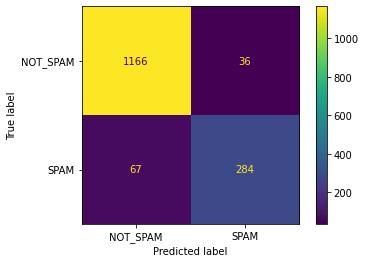

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

retrieve_spam_dataset()
test = Test()
conf_matrix, report, params = test.get_canonical_results()
test.pretty_print_2(conf_matrix, report, params)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["NOT_SPAM", "SPAM"])
disp.plot()

![canonical.png](./saved_graphs/canonical.png)

Primeramente se observa que se tiene una accuracy razonablemente alta, especialmente si se considera el número elevados de supuestos "irreales" que se utilizar en Naive Baye como independencia de una palabra respecto a su contexto ("palabras que la rodean") e independencia de una palabra respecto a su posición. No obstante, estas simplificaciones son las que permiten obtener un algoritmo con tiempos de ejecución y espacio utilizado razonables.

Luego, a primera vista se concluye que el algoritmo es sorpresivamente bueno dadas las hipótesis hechas. Esto concuerda con lo dicho en la bibliografía y las clases.

Por otro lado, claramente existe un porcentaje mucho mayor de correos que no son spam respecto a los que si son spam. Dada la matríz de confusión se ve que el algoritmo logra clasificar gran proporción de los correos que no son spam correctamente y estos conforman la mayoría de los correos, por lo que la accuracy no parece ser la mejor medida para medir el desempeño del algoritmo.

Luego, no es sorprendente que el recall y la accuracy de la clase not_spam sean elevadas.

Mirando la performance respecto a la clase spam, se obtienen resultados bastante más pobres.

Considerando el problema de clasificar mensajes como spam o no spam, es razonable que se busquen diferentes soluciones de compromiso, dependiendo de si es prioritario no mostrar ningún spam al usuario, o si es prioritario que ningún correo legítimo sea mal clasificado como spam. Según esto, y como se verá posteriormente al analizar el efecto de los metaparámetros, se tiene lugar a flexibilidad respecto a que considerar como un mal o buen clasificador y para ajustarlo a usos más específicos. No obstante, esto no quita que los resultados de la clase spam son malos, pero como se verá a continuación, ajustando metaparámetros, es posible mejorar su rendimiento. 

Para el caso del conjunto dPara el caso del conjunto de datos provisto por los docentes, se obtienen resultados muy superiores a aquellos dados por los correos personales de gmail.

Esto ilustra una constante en (casi) todos los experimentos que siguen en el informe. Cabe destacar que los datos brindados por los docentes son datos de diversas fuentes (para verificarlo ver el .csv descargado), y de correos no personalizados, o que al menos no parecen dirigidos a una población tan reducida como los integrantes de este grupo de trabajo o los estudiandes de facultad de ingeniería.

Es decir, si bien el conjunto de datos brindado por los docentes es más chico que el obtenido de gmail, se puede suponer que éste es representativo de una variedad más amplia de casillas de correo.

Por su parte, es sabido que las populares casillas de correo modernas (entre ellas gmail), refinan su clasificación según la interacción con el contenido que tiene el usuario (cosa que claramente el algoritmo implementado no tiene en cuenta) y particularmente, un correo que antes era clasificado como un spam, si es abierto por el dueño de la casilla electrónica y éste interactua con el mismo, es más probable que correos similares sean clasificados como no spam en el futuro (por ejemplo supóngase que a su correo le llegan promociones sobre PedidosYa u otra aplicación similar a la casilla de spam. Esto sucede por dos años seguidos, pero en algún momento usted decide ver las promociones de dicha aplicación, pues ahora son de interés para usted. Luego, gmail empezará a clasificar con mayor probabilidad correos de la aplicación de pedidos de comidas en cuestion hacia la bandeja de entrada en vez de spam). El caso anteriormente presentado fue visualizado en algunos correos analizados para entender intuitivamente porqué el algoritmo implementado cometía errores de clasificación. 

Este efecto, según lo que concierne al algoritmo implementado es equivalente a tener un dataset ruidoso o al menos clasificaciones "no deterministas" (es decir, "en la realidad" no existe una función f tal que dado un correo m decida si m es spam o no de forma determinista). Si bien el algoritmo presentado es robusto a este tipo de situaciones, dada una casilla de correo personalizada, donde los gustos o intereses de uno o tres individuos puede cambiar diversamente a lo largo de al menos siete años, se podría decir que existe ruido no trivial en el conjunto de datos. Cabe destacar que las aplicaciones de correo electrónico contemporáneas pueden (y tienen a su alcance) un repertorio mucho mayor de datos para determinar si un correo es spam o no, como puede ser la direccion IP del servidor SMTP que transfirió el correo, la casilla electrónica del emisor o el número de remitentes, todos factores que no se tienen en cuenta en este algoritmo.

Además, como se concluirá luego, al tratarse de contenido personalizado, es de esperar que el rendimiento del algoritmo implementado sea inferior si se utiliza como clasificador de spam en un contexto general, es decir para las casillas de correo de diversas personas.

### 3.3 Matriz de confusión y reporte del caso canónico y stemmer

Posteriormente se utiliza un stemmer sobre el caso canónico para ver si éste mejora los resultados.

Se presentan a continuación los resultados.

In [11]:
retrieve_spam_dataset()
test = Test()
test.load_params("./test_case_descriptors/canonical_with_stemmer.json")
test.run_tests()
test.pretty_print(test.test_results[0])

Using params:
m_estimator = 1
max_email_len = None
max_dataset_size = None
stem = True
count_duplicates = True
We got the following confusion matrix: 
 [[1151   51]
 [  50  301]]
And the following report: 
Accuracy: 0.9349645846748229 

SPAM:
  Precision: 0.8551136363636364 
  Recall: 0.8575498575498576 
  f1-score: 0.8563300142247511 

NOT_SPAM:
  Precision: 0.958368026644463 
  Recall: 0.9575707154742097 
  f1-score: 0.9579692051602164 




![canonical_with_stemmer.png](./saved_graphs/canonical_with_stemmer.png)

Se puede observar que la accuracy disminuye en este caso, así como todas las medidas excepto el recall y el f1-score.

Luego, no se obtienen los resultados esperados y en general los resultados son debatibles. La medida f1 mejora, así que por ese lado se podría concluir que se obtiene una mejoría leve respecto a no utilizar el stemmer. Además mejora sustancialmente el recall de la clase spam, que se puede argumentar (dado los valores presentes de las demás medidas y la flexibilidad de interpretación de un buen clasificador de spam antes mencionado) que se mejoró la medida más sustanciál para este clasificador, reduciendo marginalmente las demás. Luego, se podría concluir que el stemmer tiene un impacto positivo.

Por otro lado, se mejora el recall sobre spam a cuestas de tener un mayor porcentaje de mensajes que no son spam clasificados como spam, lo cual podría ser indeseado para esta aplicación, permitiendo concluir que el stemmer daña o al menos no mejora los resultados.

De una forma u otra, las diferencias no son realmente significativas, por lo que se concluye que el stemmer no tiene un impacto significativo en nuestro dataset.

No obstante, dado el argumento para utilizar el stemmer, era esparable una mejora mayor respecto a la obtenida, pues al eliminar derivaciones de palabras y llevarlas a su raíz se uniformiza la aparición de las palabras, permitiendo tener más datos para calcular fielmente las probabilidades utilizadas.

Dado el tamaño del dataset utilizado (aproximadamente 13.000 correos) y la relativa pequeña diversidad de los mismos, es razonable pensar que se tienen datos suficientes para calcular adecuadamente las probabilidades de cada palabra. Luego, stemming parece una técnica adecuada si se tuviera un dataset chico o con un vocabulario muy grande que no permita calcular fialmente las probabilidades necesarias.

Por su parte, es razonable que en cierto sentido se pierda calidad en las precisiones del modelo al realizar stemming, pues se normalizan constructos como los tiempos verbales.
Para ver como ésto puede afectar la calidad el modelo, se toma a modo de ejemplo los tiempos verbales. Particularmente, los tiempos verbales se pueden relacionar a la emociones que existen en un texto escrito, así como la formalidad del mismo. Claramente un spam o una promoción tiene emociones potencialemente distintas a las que uno recibiría por ejemplo en un correo de un foro de la facultad (que a los efectos del argumento se considera como no spam), e incluso el grado de formalidad cambia. Luego, perder estas características del texto conlleva a pérdida de información sobre los correos y se puede esperar por tanto una pérdida de calidad.

Considerando los resultados obtenidos, también se puede concluir que dichas propiedades, si bien pueden llegar a ayudar al algoritmo, al menos expresadas solo en términos de diferentes variaciones de una palabra (y no por ejemplo el contexto de la palabra o una clasificación sobre los sentimientos encontrados en el texto) no constituyen una diferencia significativa para el algoritmo dadas las simplificaciones realizadas.

Si bien sería necesario mayor experimentación para las conclusiones hasta ahora dichas, y en particlar para la siguiente, se deja a modo de hipótesis a comprobar y posible valor de utilizar un stemmer.

Particularmente, el stemmer permite simplificar un diccionario, permitiendo reducir entonces la cantidad de probabilidades a calcular. Luego, si se consideraran modelos markovianos (que por ejemplo miraran k palabras anteriores de un texto), también se reduce el número de probabilidades condicionales a calcular. Luego, esto permitiría acotar el tamaño del dataset necesario para lograr una buena estimación de las probabilidades condicionales y viabilizar la implementación de dicho modelo, de la misma forma que podría haber ayudado en este caso con datasets más pequeños. No obstante, los modelos de orden mayor tienen un costo computacional mucho mayor que puede hacer inviable su aplicabilidad según los recursos de cómputo al alcance. Además, es de esperar que estos modelos al considerar el contexto de las palabras, se vean más afectados por las simplificaciones realizadas por el stemmer, como fue descripto para el caso de los tiempos verbales y los sentimientos. 

### 3.4 Matriz de confusión y reporte del caso canónico y not count duplicates



In [12]:
retrieve_spam_dataset()
test = Test()
test.load_params("./test_case_descriptors/canonical_without_duplicates.json")
test.run_tests()
test.pretty_print(test.test_results[0])

Using params:
m_estimator = 1
max_email_len = None
max_dataset_size = None
stem = False
count_duplicates = False
We got the following confusion matrix: 
 [[1165   37]
 [  67  284]]
And the following report: 
Accuracy: 0.9330328396651641 

SPAM:
  Precision: 0.8847352024922118 
  Recall: 0.8091168091168092 
  f1-score: 0.8452380952380952 

NOT_SPAM:
  Precision: 0.9456168831168831 
  Recall: 0.9692179700499168 
  f1-score: 0.9572719802793757 




![canonical_without_duplicates.png](./saved_graphs/canonical_without_duplicates.png)

Para el caso de evitar contar palabras repetidas, claramente los resultados son peores, particularmente en el caso del spam.

Es esperable que los resultados empeoren, pues en un texto dado existen palabras más importante que otras, y esto en parte está dado por la cantidad de veces que la palabra aparece en dicho texto (y en general en el corpus de texto, como indica tf-idf). Luego, no es correcto considerar a todas las palabras con la misma relevancia y por tanto darles el mismo peso a sus probabilidades.

Al contar palabras duplicadas, se está en parte asignando implícitamente dicho peso (aunque de una forma no todo correcta, porque existen palabras que naturalmente aparecen más en cualquier texto, como las stop words, que para este experimento se filtram.) y por tanto parece razonable tener mejores resultados. Para potenciar y corregir este acercamiento a la importancia de las palabras, queda como posible mejora intentar incorporar la medida tf-idf como peso de las probabilidades, cosa que al momento de implementarse no pareción trivial como hacerlo, manteniendo las propiedades de una distribución de probabilidad. Luego, se intentó implementar el uso de esta medida, pero por la falta de claridad es su interpretación, se optó finalmente por no hacerlo.

Cabe destacar que el spam se ve más afectado respecto a los correos que no son spam a la eliminación de palabras duplicadas. En parte se puede explicar esto porque hay (muchos) menos correos de spam que no spam, lo que puede indicar que la diferencia está dada en parte por el tamaño de la muestra.

Por otro lado, y apelando a la intuición, existen diversas palabras que aparecen muy pocas veces en correos que no son spam y aparecen muchas veces en correos que son spam ("viagra"). Por su parte, existen otras palabras que se pueden utilizar en ambos contextos ("amigo") y su frecuencia puede ser un indicador de si la palabra aparece porque es un spam o porque no es un spam. Es decir, podría ser que los correos con spam tengan usualmente más de 3 veces escrita la palabra amigo, pero un correo que no es spam la tiene usualmente menos de 3 veces, entonces saber la frecuencia de dicha palabra en un mensaje puede refinar la clasificación. 
Para el caso de las palabras "características" de correos spam, nada impide que se usen en correos que no son spam, pero es esperable que sea mucho menos probable ver dichas palabras reiteradas veces en un correo normal respecto a verlas reiteradas veces en un spam, por lo que no contar con el numero de apariciones de la palabra en el mensaje puede también afectar negativamente la calidad de la clasificación en dichos casos.

Quizás la virtud mayor de evitar las palabras duplicadas es que se puede ahorrar tiempo de cómputo para mensajes muy largos, pues evita tener que considerar dos o más veces la probabilidad de dicha palabra en los cálculos. Además, si se deben truncar los mensajes a las primeras n palabras del mismo (supóngase por restricciones de cómputo), si primero se eliminan los duplicados y luego se trunca el mensaje a las primeras n palabras (como se hace en la implementación aquí presente), entonces de cierta forma se espera que se pueda extraer más información de un mensaje eliminando sus duplicados. Es decir, cuando el truncado del mensaje sea importate (respecto al largo del mismo), la eliminación de duplicados puede ayudar a considerar una diversidad mayor de palabras presentes en el mensaje que brinden mayor información respecto al mensaje que visualizar un palabras repetidas.

Esta última hipótesis queda como posible mejora al trabajo realizado, pero resulta particularmente dificil dado que los mensajes de los conjuntos de datos obtenidos contienen pocas palabras y por tanto se decide no experimentar con eso, pues en los resultados no sería muy significativo.

### 3.5 Matriz de confusión y reporte del caso canónico y combinaciones de m_estimador y max_email_len

En los siguientes experimentos se obtendrán las gráficas del recall y la precisión respecto al m_estimador y el max_email_len para cada clasificación posible.



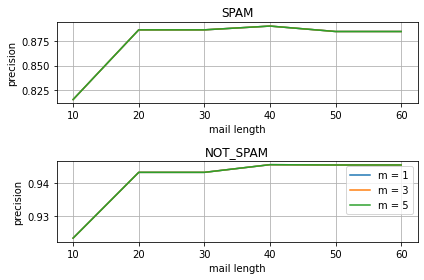

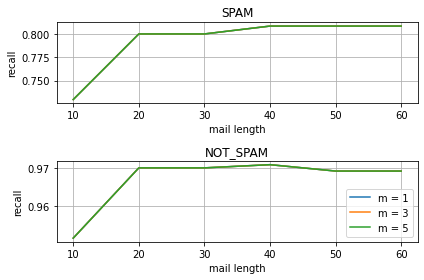

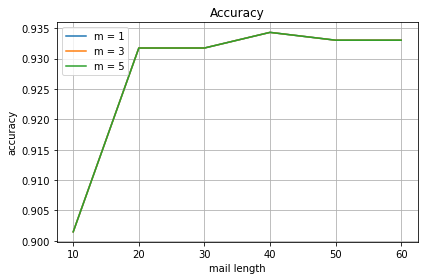

In [13]:
retrieve_spam_dataset()
test = Test()
test.load_params("./test_case_descriptors/graficas_livianas.json")
test.run_tests()
test.graph_by_len_and_m("precision")
test.graph_by_len_and_m("recall")
test.graph_accuracy_by_len_and_m()

El siguiente test realiza el mismo experimento pero con un mayor conjunto de largos de mails y valores de m, por lo tanto su coste computacional es mucho más alto y por tanto demorará mucho en caso de ser ejecutado.

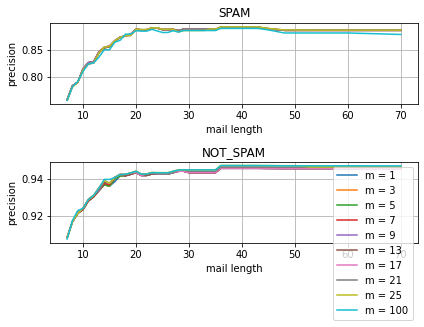

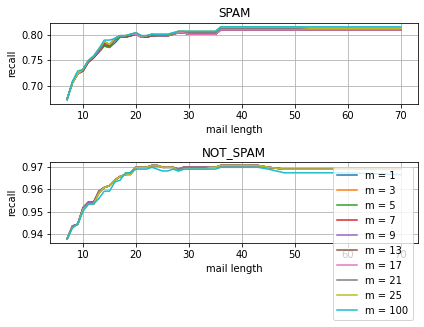

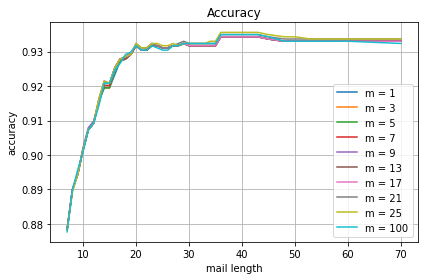

In [14]:
retrieve_spam_dataset()
test = Test()
test.load_params("./test_case_descriptors/graficas_pesadas.json")
test.run_tests()
test.graph_by_len_and_m("precision")
test.graph_by_len_and_m("recall")
test.graph_accuracy_by_len_and_m()

Resultado de correr el test anterior utilizando nuestro dataset.

![grafica_pesada_precision.png](./saved_graphs/grafica_pesada_precision.png)

![grafica_pesada_recall.png](./saved_graphs/grafica_pesada_recall.png)

![grafica_pesada_accuracy.png](./saved_graphs/grafica_pesada_accuracy.png)

Como puede observarse, mientras más largo es el email mejor resultado que obtiene el clasificador, además se observa que esta mejora ocurre de forma aparentemente independiente del m utilizado. De todas formas también se puede ver que para un m mas grande se obtienen mejores resultados.


### 3.6 Matriz de confusion y reporte del caso canonico + variando el max_dataset_size


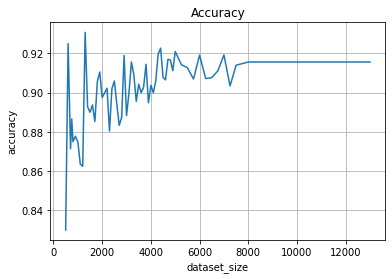

In [15]:
retrieve_spam_dataset()
test = Test()
test.load_params("./test_case_descriptors/diferentes_dataset_size.json")
test.run_tests()
test.graph_accuracy_by_max_dataset_size()

![accuracy_dataset_len_ours.png](./saved_graphs/accuracy_dataset_len_ours.png)

Para el dataset de gmail, el error (entendido como accuracy) en funcion del tamaño del dataset se comporta de manera muy irregular. Parecería que (obviando los picos y tomando una especia de "media"), la accuracy se mantiene en un rango constante al variar el tamaño del dataset. 

Contrario a lo esperable, los mejores resultados (y los peores, lo cual es bastante más razonable) se obtienen con pocos datos, pero a  medida que se incrementa el tamaño del dataset, las fluctuaciones de la grafica disminuyen.

Luego de dataset_size > 10000, como no hay más datos (efectivamente se utilizan todos los datos en el entrenamiento),  la curva ,trivialmente, permanece constante.

Para el dataset provisto por los docentes, macroscópicamente el error se reduce al aumentar el numero de datos utilizados, lo cual es esperado por la misma definición de aprendizaje automático.

Claramente el dataset de gmail es en general más suceptible a los cambios de los metaparámetros y en general se tienen cambios más inestables.
Esto se puede explicar por la distintas fuentes de datos que contiene el dataset dado por los docentes del curso (contiene correos de diversas fuentes, potencialemente de distintas personas y correos "no personalizados") que logra entonces (aunque sea una muestra más chica) un "verdadero" muestreo de la realidad o al menos más representativo que el dataset obtenido a partir de los correos de gmail de los integrantes del curso, que se ajustan a la realidad particular de tres personas.

## 4 Nube de Palabras

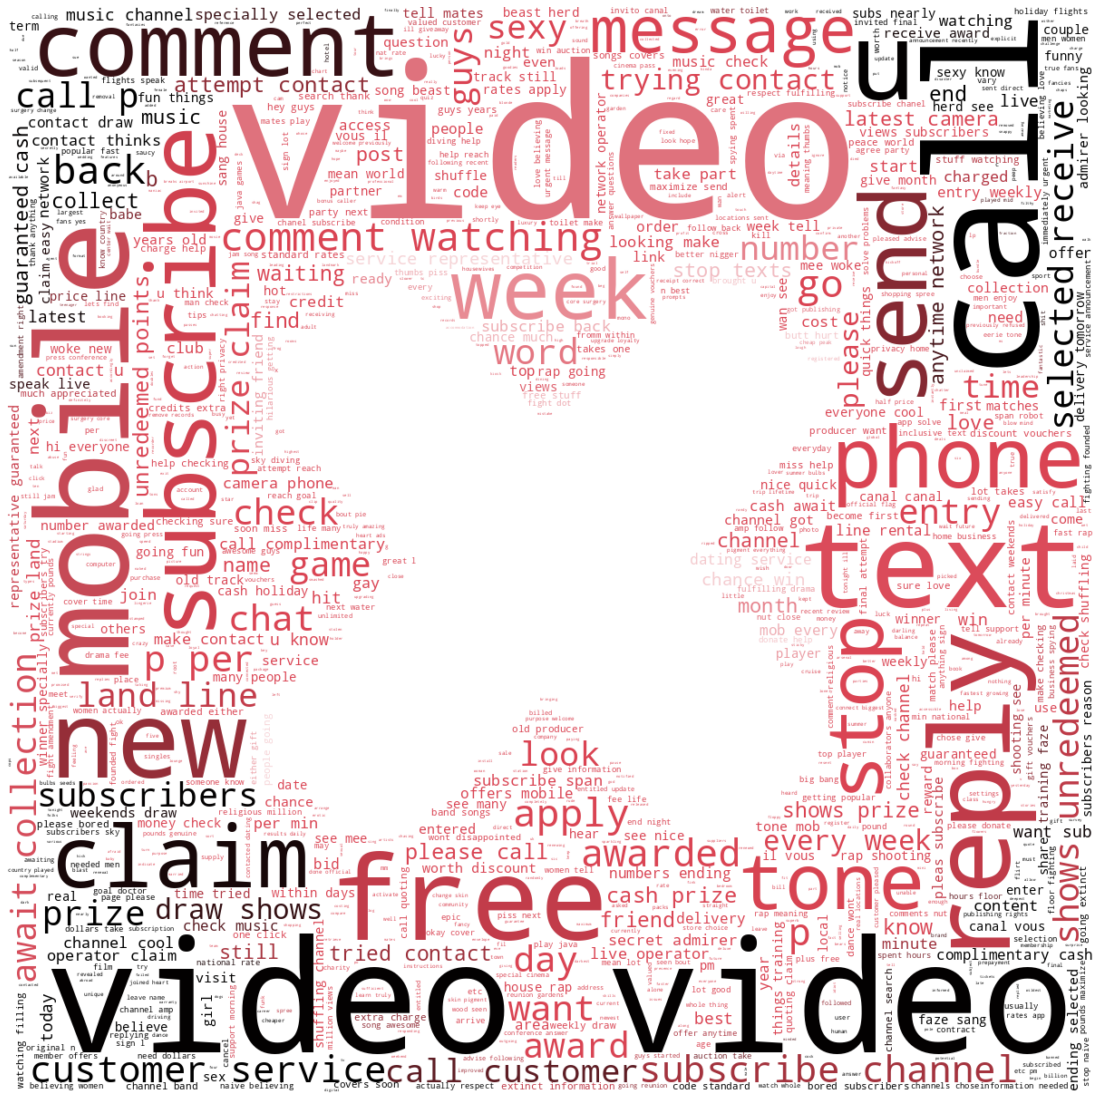

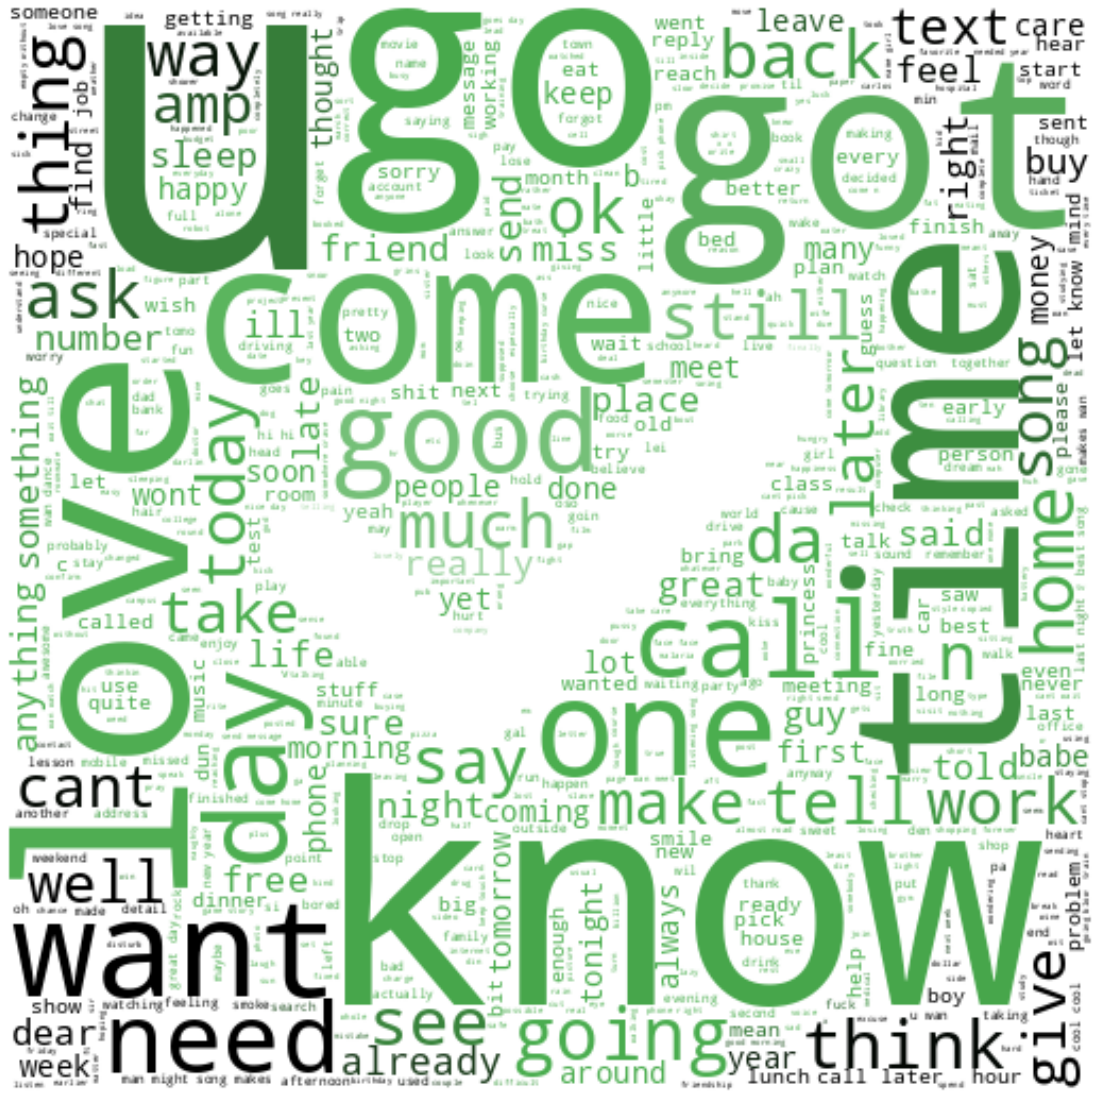

In [16]:
retrieve_spam_dataset()
CLOUD_WORD_TOP = 500000
SPAM_IMAGE_DIR = "./cloud_images/spam.png"
NOT_SPAM_IMAGE_DIR = "./cloud_images/not_spam.png"
CLOUD_NB_PARAMS = (1,None,None,False,False)

test = Test()
test.load_params(filename="./test_case_descriptors/canonical_parameters.json")
test.make_cloud(CLOUD_WORD_TOP, CLOUD_NB_PARAMS, SPAM_IMAGE_DIR, NOT_SPAM_IMAGE_DIR)

### 4.1 Nube de correos normales

Analizando las palabras más frecuentes es clara la repetición de mails del mismo tipo en el conjunto de datos. En particular, la casilla de correos normales en general solo recibe correos relacionados con videojuegos y otras actividades de ocio asociadas a las cuentas de correo. Esto demuestra las falencias del conjunto de datos, dado que aunque posiblemente clasifique correctamente dentro del universo presentado, al utilizarse el mismo modelo pre-entrenado con correos de un individuo aleatorio difícilmente logre hallar clasificaciones correctas a menos que su perfil de correo coincida con el conjunto de entrenamiento.

![not_spam_cloud.png](./saved_graphs/not_spam_cloud.png)

### 4.2 Nube de correos de spam

Para las palabras de spam, se considera que las palabras más frecuentes no parecen estar tan sesgadas como las anteriores. Sin embargo, pueden observarse palabras no tan repetidas como "play" y "game" que podrían causar confusiones a la hora de elegir una clasificación.

![spam_cloud.png](./saved_graphs/spam_cloud.png)

## 5 Análisis de clasificación incorrecta
Del conjunto de evaluación identifique correos mal clasificados y determine tres razones
diferentes por las cuales considera que la clasificación no fue correcta.

Luego de analizar los correos mal clasificados en el conjunto de datos se intenta inferir cuál es el motivo de dicho fallo en el algoritmo. Se analizará a continuación motivos específicos, de los cuales se resalta el conjunto de datos utilizado en adición al preprocesamiento y particularidades de Naive Bayes.

### 5.1 Conjunto de datos

Es un hecho que el conjunto de datos utilizado (correos de integrantes del equipo) contiene una amplia cantidad de sesgos con respecto a lo que usualmente esperaría encontrar en el usuario promedio (como correos sobre computación o sobre la universidad de ingeniería), o correos de promociones de productos particulares que detecta de forma inmediata como la categoría más frecuente. Consecuentemente, el algoritmo se reduce a realizar clasificaciones acertadas solo dentro del universo de nuestros correos, dificultándole generalizar ante datos no vistos. Como curiosidad, el corpus de brown incluye la palabra "Fing", lo cual coincide con el acrónimo de "Facultad de Ingeniería" lo cual brinda amplia información sobre la clasificación del correo.

Por otro lado, analizando el conjunto de correos se descubre que la clasificación de gmail en promociones y correos normales no siempre es consistente con todas las clasificaciones, por ejemplo, clasificando correos de ciertos cursos de la universidad poco recurrentes en promociones y a los actualmente cursados como correos normales. Esto se considera como un problema por un dato ruidoso más que por la implementación.

![correo_cdivv.png](./failed_classification_images/correo_cdivv.png)

### 5.2 Preprocesamiento

En el preprocesado es eliminada una amplia cantidad de datos considerados irrelevantes tales como números o signos de puntuación, tanto al limpiarlos manualmente como al filtrarlos del diccionario considerado. Existen múltiples correos para lo que esto podría ser perjudicial a la hora de clasificar. Un ejemplo es el siguiente:


![netflix.png](./failed_classification_images/netflix2.png)

Aquí es claro que el análisis de números tales como "+16" o "99% Match" harían la clasificación obvia. Sin embargo, lo único que se detecta en el programa luego del preprocesado no parece ser suficiente para descubrirlo:

```
['violent', 'artists', 'killers', 'terrifying', 'true', 'stories', 'worst', 'experiences', 'one', 'could', 'ever', 'imagine']
```


### 5.3 Naive Bayes

El algoritmo Naive Bayes asume que la ocurrencia de una palabra en un texto es independiente a la de otra. Está claro que esto no representa a la realidad, ya que no toma en cuenta el contexto de la palabra vista. Esto puede ser ampliamente perjudicial a la hora de observar homógrafos o una misma palabra en una situación distinta.

Un ejemplo de esto se ve a continuación, donde una promoción de microsoft, empresa de la cual uno es usuario de diversas aplicaciones, también puede interesarse en enviar correos promocionales de productos o servicios para ofrecer.

Ejemplo de correo de microsoft erróneamente clasificado como no spam:

![microsoft_not_detected_spam.png](./failed_classification_images/microsoft_not_detected_spam.png)

Ejemplo de correo de microsoft que efectivamente no es spam:

![microsoft_not_spam.png](./failed_classification_images/microsoft_not_spam.png)

## 6 Conclusiones

## 6.1 Resultados según expectativas iniciales
Inicialmente, las expectativas con respecto al algoritmo eran positivas dado el gran trabajo de preprocesado para remover signos de puntuación, stopwords, y palabras no pertenecientes al diccionario elegido, aunque no se esperaban resultados sobresalientes dadas las restricciones de Naive Bayes dada la asunción de palabras independientes en un mismo conjunto de palabras. Dado que es de esperar que en un conjunto de datos representativo tenga considerablemente menos mensajes normales que de spam, no se tenían tan altas expectativas con respecto a su clasificación en particular, dado que está claro que en caso de duda el algoritmo tenderá a inclinarse hacia la clase mayoritaria. Los resultados obtenidos sustentan esta creencia, clasificando de forma correcta a un 65% de los correos de spam, aunque para correos no spam se obtuvo 77% de correos identificados correctamente.

En cuanto a los parámetros utilizados, se esperaba una considerable mejora con respecto al uso del stemmer, el cual aunque parece no afectar el resultado utilizando nuestros correos lo empeora levemente. Sin embargo, pareció ser fundamental al trabajar con el conjunto de datos de spam brindado por docentes del curso. Por otro lado, para los parámetros de largo máximo de correo y conjunto de datos fueron, como era de esperarse, altamente perjudiciales para la efectividad del algoritmo, llegando a perder hasta un 20% de recall en el peor de los casos.

## 6.2 ¿Cuándo se dieron los mejores resultados?

Los mejores resultados del algoritmo se dieron al intentar clasificar correos normales, lo cual parece deberse a la minúscula cantidad de correos de spam en el conjunto de datos.

En cuanto a parámetros utilizados, era claro que el largo de correo y conjunto de datos iba a maximizar clasificaciones exitosas al permitir el mayor largo posible, al igual que tener en cuenta palabras duplicadas. Además, los aciertos del algoritmo parecían incrementarse monótonamente en función al valor M del M-Estimador, dando a entender que tal vez el comúnmente utilizado estimador de Laplace no siempre es la mejor clasificación, teniendo esto sentido ya que cuando m tiende a infinito el estimador resultante es el de máxima verosimilitud de una palabra en un texto, sin la característica perjudicial de hacer 0 una estimación con palabras no vistas. Por otro lado, como ya se hizo mención, el stemmer daba mejores resultados al estar desactivado.

Otro hecho a destacar es que los resultados con respecto al conjunto de datos de nuestros correos parecía obtener resultados radicalmente mejores, logrando un f1 de 84% contra el 48% obtenido con nuestros correos. Esto se justifica con el hecho de que nuestro conjunto de datos contiene mensajes acumulados durante varios años, conteniendo además clasificaciones ruidosas por parte de gmail, mientras que esto no parece ser el caso para el conjunto brindado por docentes.

## 6.3 ¿Cómo se mejorarían los resultados?

Ciertamente hay lugar para la mejora en el algoritmo, aunque dado el gran trabajo de preprocesado estas mejoras posiblemente serían poco significativas bajo la consigna de la tarea.

En cuanto al diccionario utilizado sería óptimo lograr considerar más palabras que solo las incluidas en los corpus utilizados. En particular, un estudio de las palabras con mayor relevancia en la clasificación de correos sería conveniente para no filtrar palabras que pudieran resultar de utilidad. Por otro lado, tener en cuenta el idioma del correo recibido podría detectar patrones que ayuden a la clasificación. Se intentó considerar un diccionario de forma dinámica utilizando un detector de idioma proveído por nltk aunque se decidió no seguir adelante dado el alto costo computacional y bajo acierto al clasificar correos en español que presentaba. Adicionalmente podría ser de ayuda sustituir el stemmer por un lematizador utilizando un etiquetador gramatical, aunque nuevamente esto sería nocivo para la velocidad de computo del algoritmo, además de no haber altas expectativas en cuanto a resultados luego de utilizar al stemmer. Finalmente, tomar en cuenta caracteres UTF-8 no incluidos en el diccionario sería ampliamente favorable en el caso de presentar un correo números particulares o hasta los actualmente populares emoticones.

Para el conjunto de datos hubiese sido óptimo que nuestros correos de gmail tengan correos menos repetitivos y con temas universitarios o de videojuegos. No parecería ser de ayuda ver que el algoritmo clasifica correos del mismo tipo una y otra vez ya que se reduce a encontrar palabras específicas que no permiten explotar su potencial para correos genéricos. Además, dado que ningún integrante del equipo poseía más de 10 mensajes de spam se decidió considerar correos de promociones como spam, lo cual claramente se aleja de la consigna original aunque probablemente obteniendo resultados similares.

Por otro lado, se plantearon diversas ideas para mejorar el algoritmo presentado. Una de ellas se basaba en ponderar cada palabra vista según su tf-idf utilizándola como función de probabilidad dentro del M-estimador. La otra fue ya mencionada, y se basa en contar palabras repetidas solo una vez (funcionalidad ya implementada) aunque realizando esta acción en el preprocesado con el fin de obtener mejoras en cuanto a procesamiento y memoria. 

Por último, el estudio realizado de parámetros fue en base a un conjunto de evaluación y de entrenamiento, lo cual no refleja con exactitud su efectividad real. Esto podría solventarse con el uso de un conjunto adicional de prueba que permita que los resultados obtenidos no se basen en resultados ya vistos.